# Multi-seed Grokking Results Visualization

This notebook visualizes results from multi-seed grokking experiments with:
- **Plot 1**: Accuracy + LLC × L2 Norm (dual y-axis)
- **Plot 2**: Loss + LLC × L2 Norm (dual y-axis)

All plots show mean ± range over multiple seeds.
- Main curves: Training & Test metrics
- Green dashed line (right axis): LLC × L2 Norm (product of LLC complexity and L2 parameter norm)


In [25]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [26]:
# Configuration
DATA_DIR = "/root/data1/zjj/ICML2026/grokking_full_parallel_1210_2057"
OUTPUT_DIR = "L2*LLC"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set matplotlib style for publication-quality plots
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'lines.linewidth': 2.0,
})


In [27]:
def load_seed_data(csv_path):
    """Load metrics from a single seed CSV file."""
    metrics = {'steps': [], 'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'llc': [], 'l2_norm': []}
    
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            metrics['steps'].append(int(row['steps']))
            metrics['train_loss'].append(float(row['train_loss']))
            metrics['train_acc'].append(float(row['train_acc']))
            metrics['test_loss'].append(float(row['test_loss']))
            metrics['test_acc'].append(float(row['test_acc']))
            
            # Handle NaN values in LLC
            llc_val = row['llc']
            if llc_val == 'nan' or llc_val == '':
                metrics['llc'].append(np.nan)
            else:
                metrics['llc'].append(float(llc_val))
            
            # Load L2 norm (handle missing column for backward compatibility)
            if 'l2_norm' in row:
                metrics['l2_norm'].append(float(row['l2_norm']))
            else:
                metrics['l2_norm'].append(np.nan)
    
    return metrics


def load_task_data(task_dir, wd):
    """Load all seed data for a specific task and weight decay."""
    wd_dir = os.path.join(task_dir, f"wd_{wd}")
    
    if not os.path.exists(wd_dir):
        return None
    
    all_metrics = []
    for seed_file in sorted(os.listdir(wd_dir)):
        if seed_file.endswith('.csv'):
            csv_path = os.path.join(wd_dir, seed_file)
            metrics = load_seed_data(csv_path)
            all_metrics.append(metrics)
    
    return all_metrics if all_metrics else None


In [28]:
def plot_with_llc(all_metrics, task_name, wd, save_dir):
    """Plot accuracy and loss with LLC × L2 overlay (dual y-axis for each plot)."""
    
    # Get common steps
    common_steps = all_metrics[0]['steps']
    
    # Compute statistics for each metric
    def compute_stats(key):
        data = np.array([m[key] for m in all_metrics])  # shape: (n_seeds, n_steps)
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        lower = np.min(data, axis=0)
        upper = np.max(data, axis=0)
        return mean, lower, upper
    
    train_acc_mean, train_acc_lower, train_acc_upper = compute_stats('train_acc')
    test_acc_mean, test_acc_lower, test_acc_upper = compute_stats('test_acc')
    train_loss_mean, train_loss_lower, train_loss_upper = compute_stats('train_loss')
    test_loss_mean, test_loss_lower, test_loss_upper = compute_stats('test_loss')
    l2_mean, l2_lower, l2_upper = compute_stats('l2_norm')
    
    # Process LLC data (filter NaN values)
    llc_data = np.array([m['llc'] for m in all_metrics])
    llc_mean = np.nanmean(llc_data, axis=0)
    llc_std = np.nanstd(llc_data, axis=0)
    llc_lower = np.nanmin(llc_data, axis=0)
    llc_upper = np.nanmax(llc_data, axis=0)
    
    # Compute LLC × L2 product
    llc_times_l2_data = np.array([m['llc'] for m in all_metrics]) * np.array([m['l2_norm'] for m in all_metrics])
    llc_times_l2_mean = np.nanmean(llc_times_l2_data, axis=0)
    llc_times_l2_lower = np.nanmin(llc_times_l2_data, axis=0)
    llc_times_l2_upper = np.nanmax(llc_times_l2_data, axis=0)
    
    # Filter valid LLC steps
    valid_mask = ~np.isnan(llc_mean)
    llc_steps = np.array(common_steps)[valid_mask]
    llc_times_l2_mean_valid = llc_times_l2_mean[valid_mask]
    llc_times_l2_lower_valid = llc_times_l2_lower[valid_mask]
    llc_times_l2_upper_valid = llc_times_l2_upper[valid_mask]
    
    # Color scheme
    colors = {
        'train': '#1f77b4',  # Blue
        'test': '#d62728',   # Red
        'llc_l2': '#2ca02c',    # Green
    }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # ===== Plot 1: Accuracy + LLC × L2 (dual y-axis) =====
    ax1_llc_l2 = ax1.twinx()
    
    # Plot Accuracy
    ax1.fill_between(common_steps, train_acc_lower, train_acc_upper, 
                     color=colors['train'], alpha=0.2, linewidth=0)
    ax1.plot(common_steps, train_acc_mean, label='Train Acc', 
             color=colors['train'], linewidth=2, alpha=0.9)
    
    ax1.fill_between(common_steps, test_acc_lower, test_acc_upper, 
                     color=colors['test'], alpha=0.2, linewidth=0)
    ax1.plot(common_steps, test_acc_mean, label='Test Acc', 
             color=colors['test'], linewidth=2.5, alpha=0.95)
    
    ax1.set_xlabel('Training Steps', fontweight='medium')
    ax1.set_ylabel('Accuracy', fontweight='medium')
    ax1.set_xscale('log')
    ax1.set_ylim([-0.05, 1.05])
    ax1.grid(True, alpha=0.25, linestyle='--')
    
    # Plot LLC × L2 on right y-axis
    if len(llc_steps) > 0:
        ax1_llc_l2.fill_between(llc_steps, llc_times_l2_lower_valid, llc_times_l2_upper_valid, 
                             color=colors['llc_l2'], alpha=0.15, linewidth=0)
        ax1_llc_l2.plot(llc_steps, llc_times_l2_mean_valid, label='Complexity', 
                     color=colors['llc_l2'], linewidth=2, linestyle='--', alpha=0.8)
        ax1_llc_l2.set_ylabel('Complexity', color=colors['llc_l2'], fontweight='medium')
        ax1_llc_l2.tick_params(axis='y', labelcolor=colors['llc_l2'])
        ax1_llc_l2.set_xscale('log')
    
    # Legend at bottom (horizontal layout)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_llc_l2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, 
              loc='upper center', bbox_to_anchor=(0.5, -0.12), 
              ncol=3, frameon=True, fancybox=True, shadow=False, 
              edgecolor='gray', framealpha=0.95)
    
    # ===== Plot 2: Loss + LLC × L2 (dual y-axis) =====
    ax2_llc_l2 = ax2.twinx()
    
    # Plot Loss
    ax2.fill_between(common_steps, train_loss_lower, train_loss_upper, 
                     color=colors['train'], alpha=0.2, linewidth=0)
    ax2.plot(common_steps, train_loss_mean, label='Train Loss', 
             color=colors['train'], linewidth=2, alpha=0.9)
    
    ax2.fill_between(common_steps, test_loss_lower, test_loss_upper, 
                     color=colors['test'], alpha=0.2, linewidth=0)
    ax2.plot(common_steps, test_loss_mean, label='Test Loss', 
             color=colors['test'], linewidth=2.5, alpha=0.95)
    
    ax2.set_xlabel('Training Steps', fontweight='medium')
    ax2.set_ylabel('Loss', fontweight='medium')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.25, linestyle='--')
    
    # Plot LLC × L2 on right y-axis
    if len(llc_steps) > 0:
        ax2_llc_l2.fill_between(llc_steps, llc_times_l2_lower_valid, llc_times_l2_upper_valid, 
                             color=colors['llc_l2'], alpha=0.15, linewidth=0)
        ax2_llc_l2.plot(llc_steps, llc_times_l2_mean_valid, label='Complexity', 
                     color=colors['llc_l2'], linewidth=2, linestyle='--', alpha=0.8)
        ax2_llc_l2.set_ylabel('Complexity', color=colors['llc_l2'], fontweight='medium')
        ax2_llc_l2.tick_params(axis='y', labelcolor=colors['llc_l2'])
        ax2_llc_l2.set_xscale('log')
    
    # Legend at bottom (horizontal layout)
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_llc_l2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, 
              loc='upper center', bbox_to_anchor=(0.5, -0.12), 
              ncol=3, frameon=True, fancybox=True, shadow=False, 
              edgecolor='gray', framealpha=0.95)
    
    # Title
    plt.suptitle(f"Task: {task_name} | WD: {wd} | (Mean ± Range over 3 seeds)", 
                 fontsize=14, y=0.98)
    
    plt.tight_layout(rect=[0, 0.05, 1.0, 0.96])  # Leave space for legend and title
    
    # Save with legal filename (replace superscript characters)
    safe_task_name = (task_name.replace('/', '_div_')
                                .replace('*', '_mul_')
                                .replace('+', '_plus_')
                                .replace('²', '2')
                                .replace('³', '3')
                                .replace('-', '_minus_'))
    output_path = os.path.join(save_dir, f"{safe_task_name}_wd{wd}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"✓ Saved: {output_path}")


In [29]:
# Define tasks and weight decays
tasks = [
    ('x_plus_y', 'x+y'),
    ('x-y', 'x-y'),
    ('x_mul_y', 'x*y'),
    ('x_div_y', 'x/y'),
    ('x2_plus_y2', 'x2+y2'),
    ('x2_plus_xy_plus_y2', 'x2+xy+y2'),
    ('x2_plus_xy_plus_y2_plus_x', 'x2+xy+y2+x'),
    ('x3_plus_xy', 'x3+xy'),
    ('x3_plus_xy2_plus_y', 'x3+xy2+y')
]

weight_decays = [0.0, 1.0]


In [30]:
# Generate all plots
print("="*60)
print("Generating plots with LLC overlay...")
print("="*60)

for task_dir, task_display in tasks:
    task_path = os.path.join(DATA_DIR, task_dir)
    
    if not os.path.exists(task_path):
        print(f"⚠ Skipping {task_display}: directory not found")
        continue
    
    for wd in weight_decays:
        all_metrics = load_task_data(task_path, wd)
        
        if all_metrics is None or len(all_metrics) == 0:
            print(f"⚠ No data for {task_display} WD={wd}")
            continue
        
        plot_with_llc(all_metrics, task_display, wd, OUTPUT_DIR)

print("\n" + "="*60)
print(f"All plots saved to: {OUTPUT_DIR}/")
print("="*60)


Generating plots with LLC overlay...
✓ Saved: L2*LLC/x_plus_y_wd0.0.png
✓ Saved: L2*LLC/x_plus_y_wd1.0.png
✓ Saved: L2*LLC/x_minus_y_wd0.0.png
✓ Saved: L2*LLC/x_minus_y_wd1.0.png
✓ Saved: L2*LLC/x_mul_y_wd0.0.png
✓ Saved: L2*LLC/x_mul_y_wd1.0.png
✓ Saved: L2*LLC/x_div_y_wd0.0.png
✓ Saved: L2*LLC/x_div_y_wd1.0.png
✓ Saved: L2*LLC/x2_plus_y2_wd0.0.png
✓ Saved: L2*LLC/x2_plus_y2_wd1.0.png
✓ Saved: L2*LLC/x2_plus_xy_plus_y2_wd0.0.png
✓ Saved: L2*LLC/x2_plus_xy_plus_y2_wd1.0.png
✓ Saved: L2*LLC/x2_plus_xy_plus_y2_plus_x_wd0.0.png
✓ Saved: L2*LLC/x2_plus_xy_plus_y2_plus_x_wd1.0.png
✓ Saved: L2*LLC/x3_plus_xy_wd0.0.png
✓ Saved: L2*LLC/x3_plus_xy_wd1.0.png
✓ Saved: L2*LLC/x3_plus_xy2_plus_y_wd0.0.png
✓ Saved: L2*LLC/x3_plus_xy2_plus_y_wd1.0.png

All plots saved to: L2*LLC/



Example plot: x2_plus_xy_plus_y2_plus_x_wd0.0.png


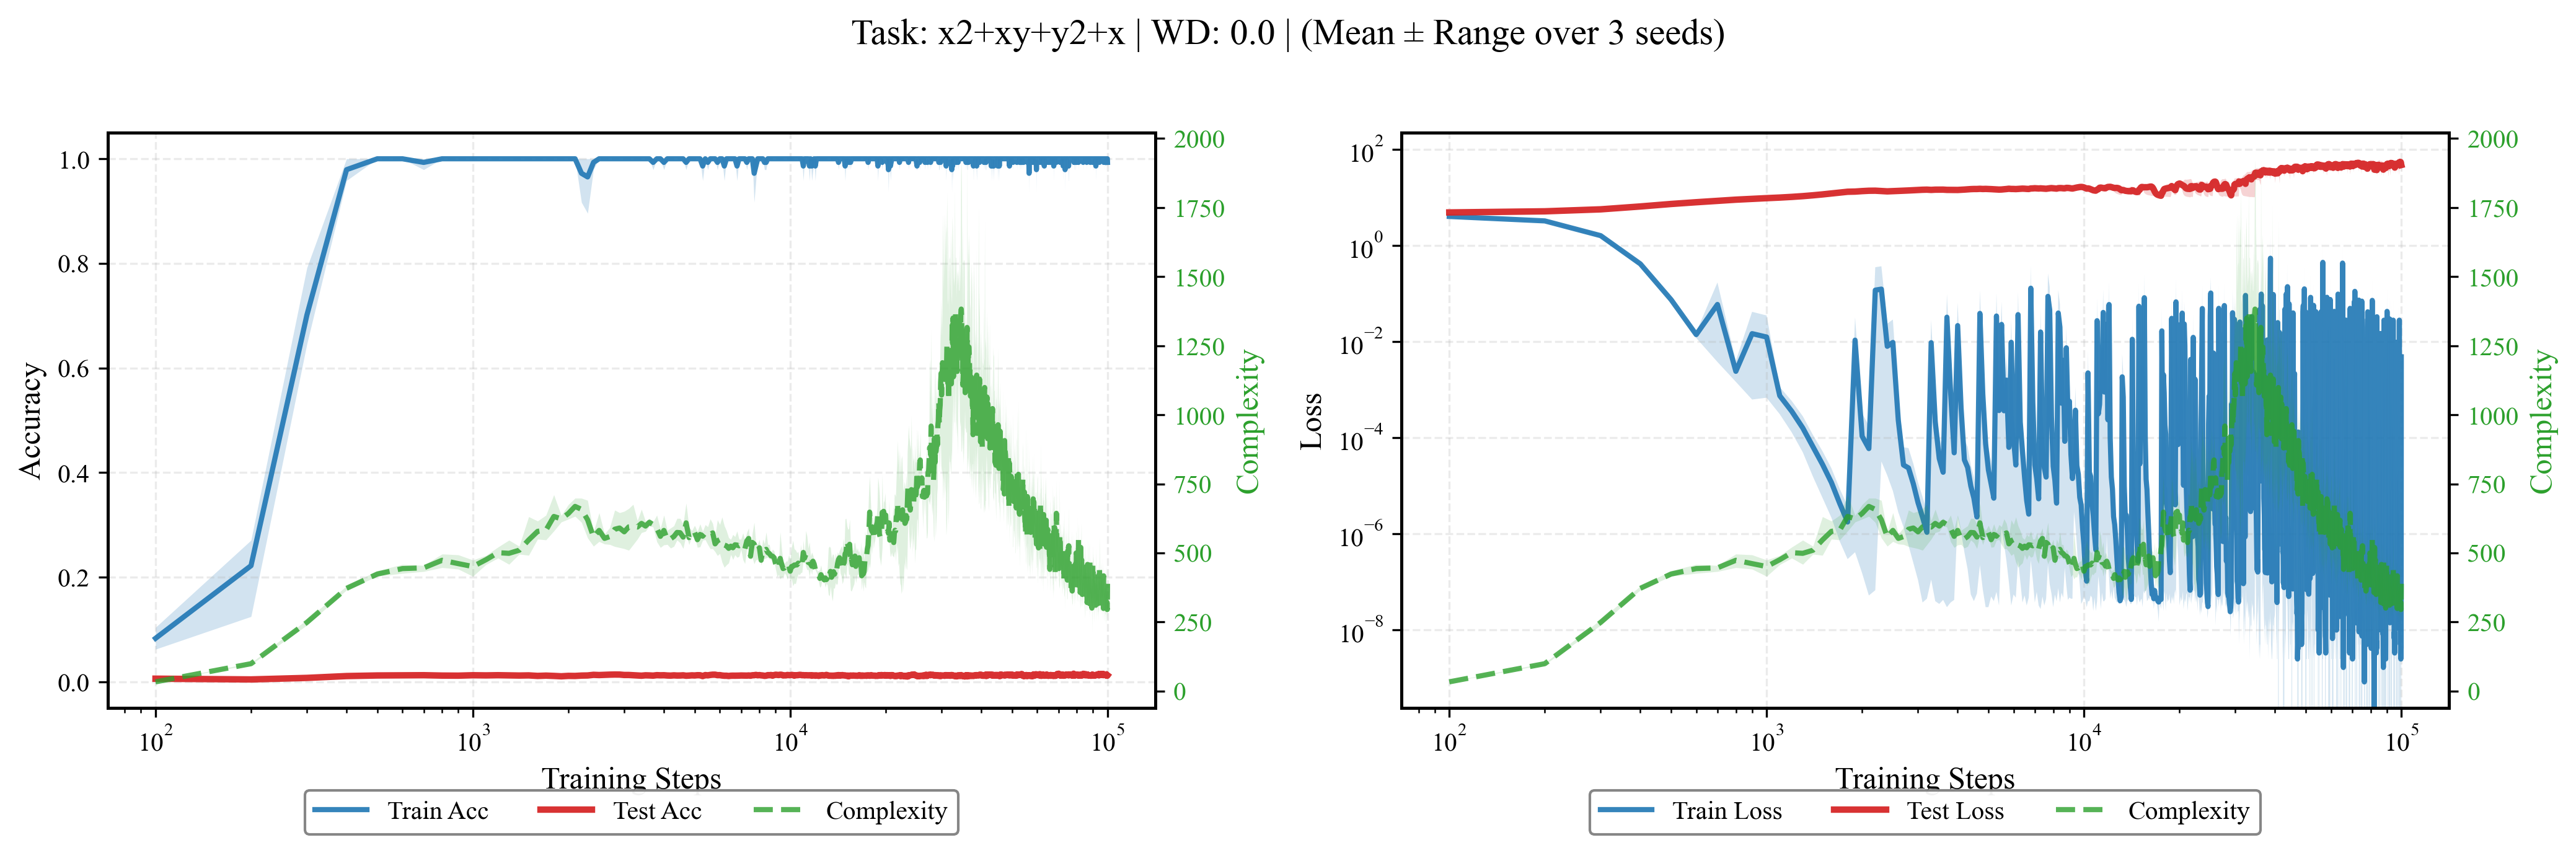

In [31]:
# Optional: Display one example plot
from IPython.display import Image, display

# Show the first generated plot as example
example_plots = sorted([f for f in os.listdir(OUTPUT_DIR) if f.endswith('.png')])
if example_plots:
    print(f"\nExample plot: {example_plots[0]}")
    display(Image(filename=os.path.join(OUTPUT_DIR, example_plots[0])))


<>:159: SyntaxWarning: invalid escape sequence '\h'
<>:159: SyntaxWarning: invalid escape sequence '\l'
<>:159: SyntaxWarning: invalid escape sequence '\h'
<>:159: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_558129/996455389.py:159: SyntaxWarning: invalid escape sequence '\h'
  ax_bot.text(0.05, 0.85, f'$\hat{{\lambda}} = {lambda_hat_val}$', transform=ax_bot.transAxes,
/tmp/ipykernel_558129/996455389.py:159: SyntaxWarning: invalid escape sequence '\l'
  ax_bot.text(0.05, 0.85, f'$\hat{{\lambda}} = {lambda_hat_val}$', transform=ax_bot.transAxes,
/tmp/ipykernel_558129/996455389.py:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


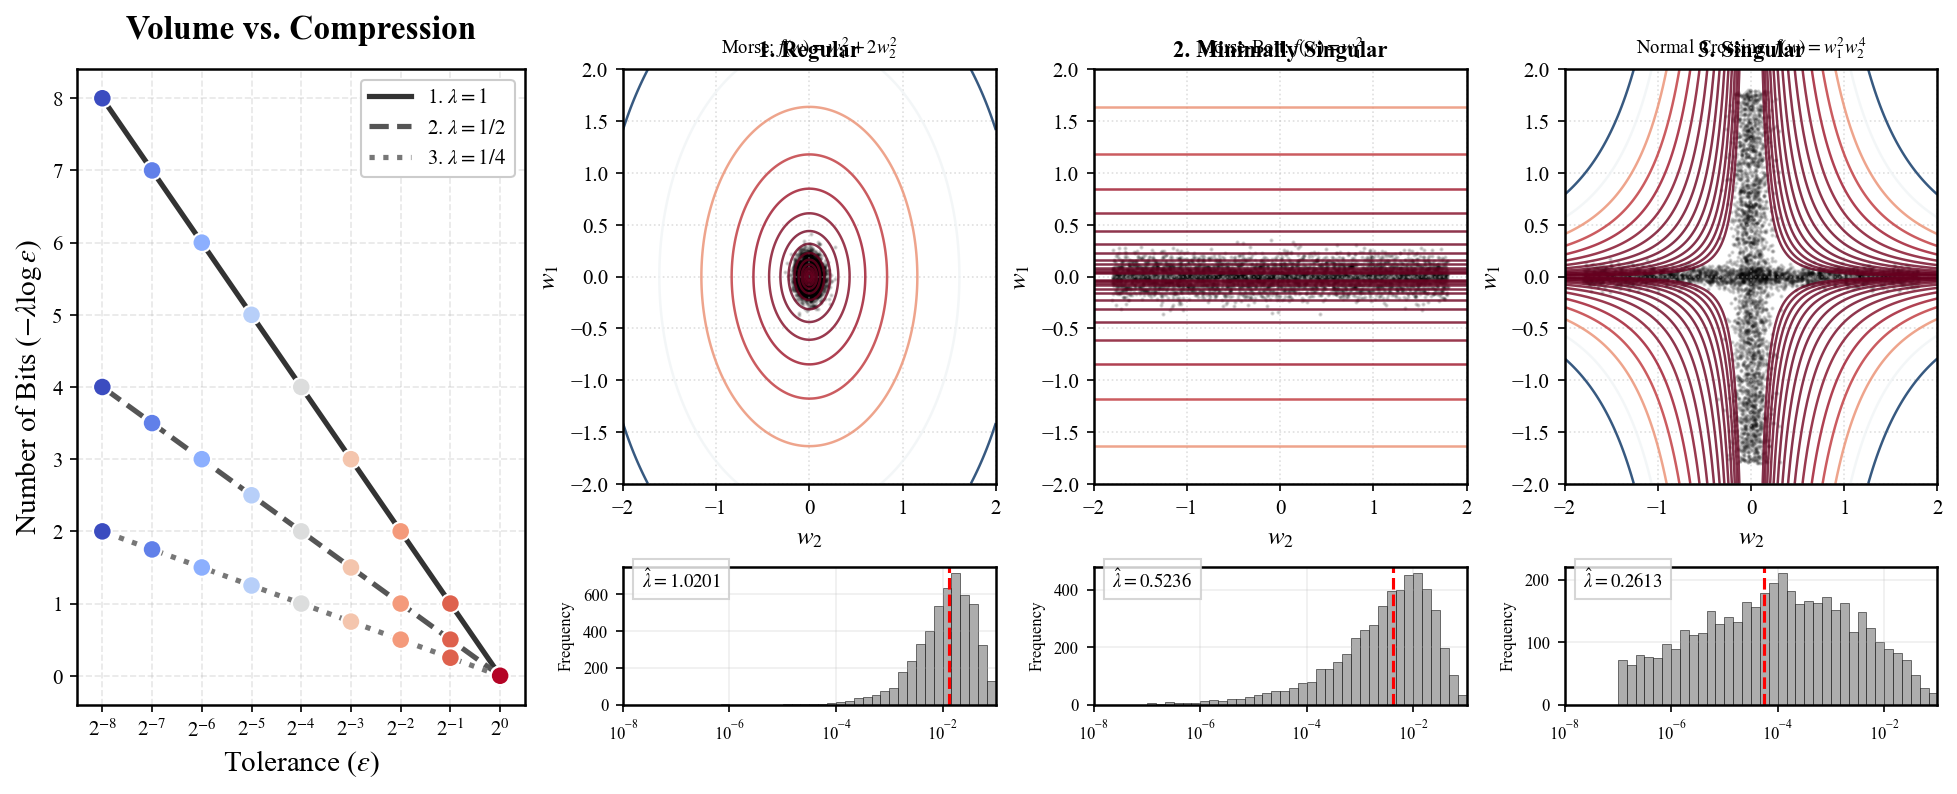

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# 设置科研绘图风格
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'mathtext.fontset': 'stix',
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 150
})

def create_scientific_plot():
    # 创建画布布局
    fig = plt.figure(figsize=(16, 5.5))
    gs = gridspec.GridSpec(2, 4, width_ratios=[1.2, 1, 1, 1], height_ratios=[1.5, 0.5], wspace=0.25, hspace=0.3)

    # ==========================================
    # 1. 左图: Volume vs. Compression
    # ==========================================
    ax_left = fig.add_subplot(gs[:, 0])
    
    # 数据生成
    epsilons = np.array([2**(-i) for i in range(9)]) # 2^0 to 2^-8
    log_eps = -np.log2(epsilons) # 0 to 8
    
    lambdas = [1.0, 0.5, 0.25]
    styles = ['-', '--', ':']
    colors = ['#333333', '#555555', '#777777']
    labels = [r'1. $\lambda=1$', r'2. $\lambda=1/2$', r'3. $\lambda=1/4$']
    
    # 颜色映射 (从蓝到红，对应epsilon从大到小)
    cmap = plt.get_cmap('coolwarm')
    
    for lam, style, color, label in zip(lambdas, styles, colors, labels):
        # 绘制线条
        y_vals = lam * log_eps
        ax_left.plot(log_eps, y_vals, linestyle=style, color=color, linewidth=2.5, label=label, zorder=1)
        
        # 绘制散点 (带渐变色)
        sc = ax_left.scatter(log_eps, y_vals, c=log_eps, cmap='coolwarm_r', s=80, zorder=2, edgecolors='white')

    # 左图装饰
    ax_left.set_title("Volume vs. Compression", fontsize=16, fontweight='bold', pad=15)
    ax_left.set_xlabel(r"Tolerance ($\varepsilon$)", fontsize=14)
    ax_left.set_ylabel(r"Number of Bits ($-\lambda \log \varepsilon$)", fontsize=14)
    
    # X轴刻度设置
    ax_left.set_xticks(log_eps)
    ax_left.set_xticklabels([f'$2^{{{-int(x)}}}$' for x in log_eps])
    ax_left.invert_xaxis() # 从 2^-8 到 2^0 实际上数值在变大，但图上是从左到右epsilon变大? 
    # 原图是从左(2^-8)到右(2^0)。左边是高精度(小epsilon)，右边是低精度。
    # 原图左边y值高(高bits)，右边y值低。
    # log_eps为 [0, 1, ... 8]。如果x轴显示epsilon，左边应该是2^-8。
    # 让我们调整坐标轴顺序以匹配原图
    ax_left.set_xlim(8.5, -0.5) 
    
    ax_left.grid(True, linestyle='--', alpha=0.3)
    ax_left.legend(loc='upper right', frameon=True, framealpha=1, edgecolor='#cccccc')

    # ==========================================
    # 2. 右图: Loss Landscapes (3列)
    # ==========================================
    
    # 定义绘图辅助函数
    def plot_landscape_column(col_idx, title, func, lambda_hat_val, scale_w1=1, scale_w2=1, singular_type='regular'):
        # 子图位置
        ax_top = fig.add_subplot(gs[0, col_idx + 1])
        ax_bot = fig.add_subplot(gs[1, col_idx + 1])
        
        # --- 上部分：等高线与散点 ---
        
        # 网格数据
        w1 = np.linspace(-2, 2, 200)
        w2 = np.linspace(-2, 2, 200)
        W1, W2 = np.meshgrid(w1, w2)
        
        # 计算Loss Z
        if singular_type == 'regular':
            Z = W1**2 + 2*W2**2
            # 模拟采样: 高斯分布
            samples_w1 = np.random.normal(0, 0.1, 5000)
            samples_w2 = np.random.normal(0, 0.1/np.sqrt(2), 5000)
            
        elif singular_type == 'minimal': # Morse-Bott w1^2 (loss depends on w1, valley along w2)
            # 注意：原图看起来像是水平线，说明Loss只随Y轴(w1)变化
            Z = W1**2 
            # 模拟采样: w1集中，w2均匀分布
            samples_w1 = np.random.normal(0, 0.1, 5000)
            samples_w2 = np.random.uniform(-1.8, 1.8, 5000)
            
        elif singular_type == 'singular': # w1^2 * w2^4
            Z = (W1**2) * (W2**4)
            # 模拟采样: 集中在坐标轴附近的十字形
            # 混合两个高斯分布：一个压扁在x轴，一个压扁在y轴
            n_samples = 5000
            mask = np.random.rand(n_samples) > 0.5
            s1_w1 = np.random.normal(0, 0.05, n_samples)
            s1_w2 = np.random.uniform(-1.8, 1.8, n_samples)
            
            s2_w1 = np.random.uniform(-1.8, 1.8, n_samples)
            s2_w2 = np.random.normal(0, 0.1, n_samples) # w2^4 means broader valley than w1^2? No, flatter.
            
            samples_w1 = np.where(mask, s1_w1, s2_w1)
            samples_w2 = np.where(mask, s1_w2, s2_w2)
        
        # 绘制等高线 (自定义Levels让线条更美观)
        levels = np.logspace(-3, 1, 15)
        # 使用 RdBu_r colormap (红=低loss, 蓝=高loss)
        cntr = ax_top.contour(W2, W1, Z, levels=levels, cmap='RdBu', linewidths=1.2, alpha=0.8)
        
        # 绘制散点 (模拟后验采样)
        ax_top.scatter(samples_w2, samples_w1, s=1, c='black', alpha=0.15)
        
        # 装饰 Top
        ax_top.set_title(title, fontsize=11, fontweight='bold')
        ax_top.set_xlim(-2, 2)
        ax_top.set_ylim(-2, 2)
        ax_top.set_xlabel('$w_2$')
        ax_top.set_ylabel('$w_1$')
        ax_top.grid(True, linestyle=':', alpha=0.4)
        
        # 在Title下方添加公式文本 (模拟原图)
        if singular_type == 'regular':
            formula = r"Morse: $f(w) = w_1^2 + 2w_2^2$"
        elif singular_type == 'minimal':
            formula = r"Morse-Bott: $f(w) = w_1^2$"
        else:
            formula = r"Normal Crossing: $f(w) = w_1^2 w_2^4$"
        ax_top.text(0.5, 1.02, formula, transform=ax_top.transAxes, ha='center', va='bottom', fontsize=9)

        # --- 下部分：直方图 ---
        
        # 计算样本Loss
        if singular_type == 'regular':
            losses = samples_w1**2 + 2*samples_w2**2
        elif singular_type == 'minimal':
            losses = samples_w1**2
        else:
            losses = (samples_w1**2) * (samples_w2**4)
            
        # 绘制直方图 (Log scale x axis mostly)
        bins = np.logspace(-7, -0.5, 40)
        ax_bot.hist(losses, bins=bins, color='#999999', edgecolor='black', linewidth=0.3, alpha=0.8)
        
        # 绘制 lambda hat 竖线
        # 我们这里不真实计算，只是画一条线示意位置
        mean_loss = np.median(losses) # 仅作示意
        ax_bot.axvline(mean_loss, color='red', linestyle='--', linewidth=1.5)
        
        # 文本框显示 lambda hat
        ax_bot.text(0.05, 0.85, f'$\hat{{\lambda}} = {lambda_hat_val}$', transform=ax_bot.transAxes, 
                    fontsize=9, bbox=dict(facecolor='white', alpha=0.8, edgecolor='#cccccc'))

        # 装饰 Bottom
        ax_bot.set_xscale('log')
        ax_bot.set_ylabel('Frequency', fontsize=8)
        ax_bot.tick_params(axis='both', which='major', labelsize=8)
        ax_bot.grid(True, which="both", ls="-", alpha=0.2)
        ax_bot.set_xlim(1e-8, 1e-1)

    # 绘制三列
    plot_landscape_column(0, "1. Regular", None, "1.0201", singular_type='regular')
    plot_landscape_column(1, "2. Minimally Singular", None, "0.5236", singular_type='minimal')
    plot_landscape_column(2, "3. Singular", None, "0.2613", singular_type='singular')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    create_scientific_plot()